# A/B Testing

## Acknowledgment 

Some of the content here is based on [Computational and Inferential Thinking: The Foundations of Data Science](https://inferentialthinking.com/chapters/intro.html), by A. Adhikari, J. DeNero, D. Wagner.

On the other hand, this text uses its own module `datascience` for data frame manipulations, while we will use pandas, which is the most commonly used library for data frames in Python.

## Importing Modules

Let's start by importing the necessary modules:

In [1]:
import numpy as np

import pandas as pd
# pd.options.future.infer_string = True
# pd.options.mode.copy_on_write = True

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 6)  # default figure size
plt.style.use("ggplot")  # style sheet

from tqdm.notebook import tqdm

## Introduction

Often we are faced with questions about *association* between two variables, meaning that a change in one variable usually comes with a change in the other.

Here we will investigate this sorts of questions when one of the variable breaks the data in two distinct categories.  For example:

* Is a person a smoker or non-smoker?
* Did a person received a treatment or not (i.e., received a [placebo](https://en.wikipedia.org/wiki/Placebo) instead)?
* Does the person exercise regularly or not?

Each of this can be associated (or not) to another variable, for example:

* Does the person have lung cancer?
* Does the person recover from the disease?
* What is the person's weight?


### Association is Not Causation

The fact that two variables are associated does not imply that there is actual causation.

For example, if students living in a particular region of a town have higher SAT scores, the fact that they actually live there is not what is causing this result.  More likely is that the schools in the region are better.  Or maybe it is more privileged area, where students are well fed, don't have to work while studying, have a stable home, etc.  Any of these other factors (or a combination of them) is more likely to *cause* the effect that students have higher SAT scores than the geographical location.

On the other hand, we see quite often association being conflated with causation.  But, **association does not imply causation**.  Extra steps are need to establish actual causation.  

One way to establish causation (although not always possible to do in practice) is to verify that *all* other variables between individuals in the two different categories have the exact same distribution (or as close as possible).


## Smoking and Birth Weight

The file [baby.csv](baby.csv) (provided with this notebook) contains the following variables for 1,174 mother-baby pairs:

- birth weight in ounces, 
- the number of gestational days, 
- the mother's age, 
- the mother's height in inches, 
- pregnancy weight in pounds, 
- and whether or not the mother smoked during pregnancy.

In [2]:
births = pd.read_csv("baby.csv")
births

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False
...,...,...,...,...,...,...
1169,113,275,27,60,100,False
1170,128,265,24,67,120,False
1171,130,291,30,65,150,True
1172,125,281,21,65,110,False


**Question:** Does maternal smoking affect birth weight?

We'll start by selecting just `Birth Weight` and `Maternal Smoker`. There are 715 non-smokers among the women in the sample, and 459 smokers.

In [3]:
smoking_and_birthweight = births[["Maternal Smoker", "Birth Weight"]]

In [4]:
smoking_and_birthweight.groupby("Maternal Smoker").size().to_frame("Count")

,Count
Maternal Smoker,
False,715
True,459


Let's look at the distribution of the birth weights of the babies of the non-smoking mothers compared to those of the smoking mothers.

The function below allows use to overlay two histograms to inspect the differences in the distributions:

In [5]:
def overlaid_hist(df, column, by, bins=10, alpha=0.7):
    """
    Given a data frame, a column for the histogram, and another
    one (by) to break up the values by, display overlaid histograms
    for each value of the the by-column.

    INPUTS"
    df: data frame containing the data for the scatter plot;
    column: the column label for the data in question;
    by: label for the column with the category by which we split the plot (one per category);
    bins: number of equally spaced bins, or list/array giving the bins;
    alpha: level of transparency (between 0 (opaque) and 1 (invisible))

    OUTPUT:
    Overlaid histograms for each category given by column "by".
    """

    # check if bins is integer
    # if so, define the bins in equal parts
    if isinstance(bins, int):
        numb_bins = bins
        bins = np.linspace(
            df[column].min(),
            df[column].max(),
            numb_bins,
        )

    # values to group by
    values = np.sort(df[by].unique())

    # initialize plot
    fig, ax = plt.subplots()

    # histograms
    for value in values:
        df.loc[df[by] == value].hist(
            column,
            density=True,
            ec="white",
            bins=bins,
            alpha=alpha,
            label=str(value),
            ax=ax,
        )

    plt.legend()

Applying to our data, we can compare the distribution of birth weights between smoking and non-smoking mothers:

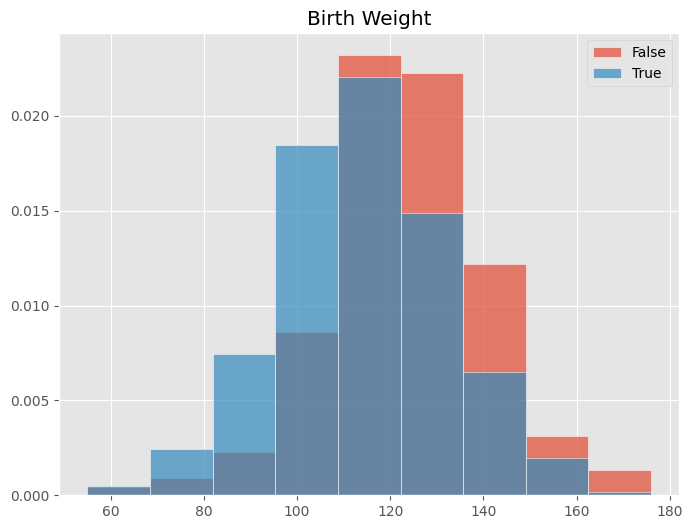

In [6]:
overlaid_hist(smoking_and_birthweight, "Birth Weight", "Maternal Smoker")

The distribution of the weights from smoking mothers appears to be shifted slightly to the left and to have lower average.

Let's also look at the average of the birth weights between the two groups:

In [7]:
means_df = smoking_and_birthweight.groupby("Maternal Smoker").mean()

means_df

,Birth Weight
Maternal Smoker,
False,123.085315
True,113.819172


The average birth weight for non-smoking mothers is almost 10 ounces higher.

Could it be that we are just seeing a difference simply due to random variations of birth weights, or is there an association between smoking and birth weights?

Here then have:

* **Null hypothesis:** The distribution of birth weights of babies is the same for mothers who don't smoke as for mothers who do. (The difference in the sample is simply due to chance.)
* **Alternative hypothesis:** The babies of the mothers who smoke have a lower birth weight, on average, than the babies of the non-smokers.

But how can we test our hypotheses in this case?

**Main idea:**  If smoking or not makes no difference (i.e., if the null hypothesis is true), then if we switch the labels between smoking and non-smoking, we should see similar differences showing up frequently.

### Test Statistic

We need to decide on some statistic (some aspect of the data) to help us analyze if the data is consistent with simple random variations of birth weights.  One idea is to use the *difference between the average birth weight of newborns by smoking and non-smoking mothers*.

Thus, small values, meaning negative numbers of large absolute value, support the alternative hypothesis.

The observed difference was about $-9.27$ ounces:

In [8]:
observed_difference = means_df.loc[True, "Birth Weight"] - means_df.loc[False, "Birth Weight"]

observed_difference

-9.266142572024918

But, again, we must verify if we could achieve the same difference simply due to random variations of birth weights.

Since we will need to compute this difference in all our simulations, let's write a function to do the job. The function takes two arguments:

- the data frame,
- the label of the column that contains the Boolean variable for grouping.

It returns the difference between the averages of the `True` group and the `False` group.

In [9]:
def difference_of_means(df, group_label):
    """
    Returns the difference between the average Birth Weights of two groups given in column
    group_label.

    INPUTS:
    df: data frame;
    group_label: column label that indicates the group to which the row belongs.

    OUTPUT:
    Difference of mean birth weights of the two groups.
    """
    reduced = df[["Birth Weight", group_label]]
    means_df = reduced.groupby(group_label).mean()
    means = means_df.iloc[:, 0]
    return means.iloc[1] - means.iloc[0]

To check that the function is working, let's use it to calculate the observed difference between the mean birth weights of the two groups in the sample.

In [10]:
difference_of_means(births, "Maternal Smoker")

-9.266142572024918

That's the same as the value of `observed_difference` calculated earlier.

### Predicting the Statistic Under the Null Hypothesis

Let's now implement our idea to deal with this problem: let's shuffle the labels and see what difference of averages we obtain.

We will have to repeat this many times, but let's show how it is done.

The first thing we need to do is to *shuffle* the labels in the Maternal Smoker column.  We can do this with the method `.sample(frac=1)`.  (The `.sample` method draws random rows *without repetition*, and `frac=1` tells it to draw the same number as the total number of rows, effectively just shuffling the column.)  We also need to reset the index of the shuffled data frame (and drop the old one), so that when adding a new column, the labels do not end up in the same position!

In [11]:
# shuffle labels
shuffled_labels = (
    smoking_and_birthweight["Maternal Smoker"].sample(frac=1).reset_index(drop=True)
)

# add to data frame
original_and_shuffled = smoking_and_birthweight.assign(tmp_name=shuffled_labels).rename(
    columns={"tmp_name": "Shuffled Label"}
)

original_and_shuffled

,Maternal Smoker,Birth Weight,Shuffled Label
0,False,120,False
1,False,113,False
2,True,128,False
3,True,108,False
4,False,136,False
...,...,...,...
1169,False,113,True
1170,False,128,False
1171,True,130,False
1172,False,125,False


Each baby's mother now has a random smoker/non-smoker label in the column `Shuffled Label`, while her original label is in `Maternal Smoker`. If the null hypothesis is true, all the random re-arrangements of the labels should be equally likely.

Let's see how different the average weights are in the two randomly labeled groups.

In [12]:
difference_of_means(original_and_shuffled, "Shuffled Label")

0.5176379176379129

The averages of the two randomly selected groups are quite a bit closer than the averages of the two original groups. We can use our function `difference_of_means` to find the two differences.

Again, we need to repeat this process many times, so let's write a function to do the job:

In [13]:
def one_simulated_difference_of_means():
    """
    Shuffle Maternal Smoking labels, and give the difference of the averag birth weights.

    INPUT:
    None.

    OUTPUT:
    Difference between average birth weights of babies of smokers and non-smokers 
    after shuffling labels.
    """

    # array of shuffled labels
    shuffled_labels = births["Maternal Smoker"].sample(frac=1).reset_index(drop=True)

    # data frame of birth weights and shuffled labels
    shuffled_df = (
        births[["Birth Weight"]]
        .assign(tmp_name=shuffled_labels)
        .rename(columns={"tmp_name": "Shuffled Label"})
    )

    return difference_of_means(shuffled_df, "Shuffled Label")

Run the cell below a few times to see how the output changes.

In [14]:
one_simulated_difference_of_means()

-0.995539101421457

### Testing

Let's shuffle the labels 5,000 times and collect the differences.

In [15]:
repetitions = 5_000

# initialize array with differences with zeros
differences = np.zeros(repetitions, dtype=float)

for i in tqdm(range(repetitions)):
    new_difference = one_simulated_difference_of_means()  # one difference
    differences[i] = new_difference  # add difference to array

  0%|          | 0/5000 [00:00<?, ?it/s]

Now we can see how often we had differences equal or less (since smaller values support the *alternative* hypothesis):

In [16]:
np.count_nonzero(differences <= observed_difference)

0

So, in all our 5,000 tries, we never obtained a single difference equal or smaller than the observed.  In other words, the $p$-value here was $0$.  We then can safely accept the alternative hypothesis that smoking mother have lighter babies.

Let's find the boundaries for statistically significant and highly statistically significant values:

In [17]:
significant = np.percentile(differences, 5)
highly_significant = np.percentile(differences, 1)

print(f"Statistically significant:        {significant:.2f}")
print(f"Highly statistically significant: {highly_significant:.2f}")

Statistically significant:        -1.81
Highly statistically significant: -2.52


So, our observed difference was very far off!

Let's visualize the distribution:

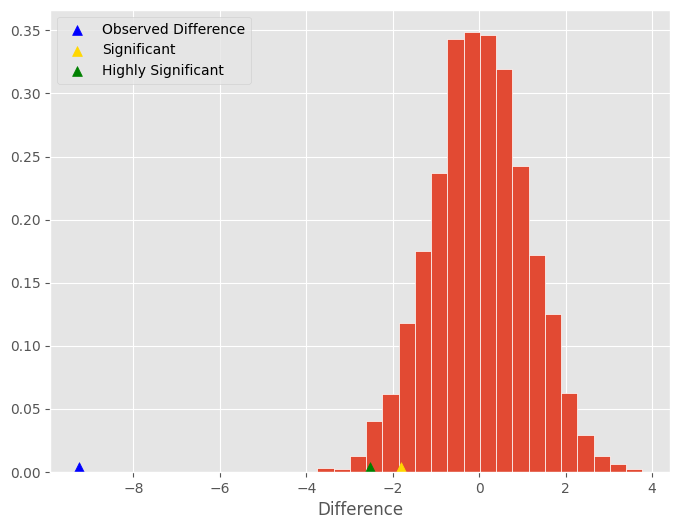

In [18]:
# distribution of differences
plt.hist(differences, density=True, ec="white", bins=20)

# observed difference
plt.scatter(
    observed_difference, 0, c="blue", marker="^", s=200, label="Observed Difference"
)


# significant value
plt.scatter(significant, 0, c="gold", marker="^", s=200, label="Significant");

# highly significant value
plt.scatter(highly_significant, 0, c="green", marker="^", s=200, label="Highly Significant")

plt.xlabel("Difference")

plt.legend(markerscale=0.5);

### Causation?

Can we say the smoking *causes* mothers to have lighter babies?

Not with the data at our disposal.  We have no control over other variables about the mothers.

## Drug Trial

### Randomized Controlled Trial

Drug test are (usually) done with *randomized controlled trials (RCT)*: in these a selected group of individuals are *randomly* divided in two groups:

* the *treatment* group, which will receive the drug, and
* the *control* group, which will receive the placebo (something with no real medical effect, e.g., a sugar pill).

Usually these are *blind studies*, meaning the the patients do not know to which group they belong.  This is important, as sometimes your psychological state can affect the outcome, so it is important to eliminate that possibility.

Moreover, often these studies are *double blind*, so the doctors treating the patients do not know themselves which patients are in each group, ensuring that they do not offer different treatments.

#### Towards Causation

Note that these groups being *randomly* selected between the candidates helps ensure that the participants in the groups will (most likely) have no other universal common characteristic, besides receiving the drug.  This goes a long way towards causality!

Note that in our previous example, we did not (and could not) randomly select which mothers would smoke, and which would not.  (If we could, we would be much closer to establishing causality!)

So, for instance, maybe mother who smoke are more likely to drink (alcoholic beverages), and the *alcohol* caused the birth weight difference, and not the smoking.  (This is what we call a *confounding factor*.)

But, in that case, if we could *randomly* select which mothers would smoke and which would not, the two groups would likely have the same proportions of drinkers and non-drinkers, and we would be able to see that the smoking did not affect the weight!

### The Trial: Chronic Back Pain:

A [randomized controlled trial (RCT)](https://www.ncbi.nlm.nih.gov/pubmed/11376175) examined the effect of using Botulinum Toxin A (BTA) as a treatment.

Thirty one patients with low-back pain were randomized into treatment and control groups, with 15 in the treatment group and 16 in control. 

The trials were run double-blind so that neither doctors nor patients knew which group they were in.

Eight weeks after the start of the study, nine of the 15 in the treatment group and two of the 16 in the control group had pain relief (according to a precise definition used by the researchers). These data are in the file [bta.csv](bta.csv) (provided with this notebook).

In [19]:
bta = pd.read_csv("bta.csv")
bta

,Group,Result
0,Control,1.0
1,Control,1.0
2,Control,0.0
3,Control,0.0
4,Control,0.0
5,Control,0.0
6,Control,0.0
7,Control,0.0
8,Control,0.0
9,Control,0.0


(**Note:** `1.0` means that the patient had some pain relief and `0.0` means they did not.)

Let's see how many patients recovered in each group. Remember that counting is the same as adding zeros and ones. The sum of 1's in the control group is the number of control group patients who had pain relief. 

In [20]:
bta.groupby("Group").sum()

,Result
Group,
Control,2.0
Treatment,9.0


Since counting is the same as the *sum* of zeros and ones, the *proportion* of patients who had pain relief is the *average* of zeros and ones. It is the sum divided by the total number of patients in each group.

In [21]:
bta.groupby("Group").mean()

,Result
Group,
Control,0.125
Treatment,0.600


In the treatment group, 60% of the patients had pain relief, compared to only 12.5% in the control group. None of the patients suffered any side effects. 

So the indications are that botulinum toxin A did better than the saline. But the conclusion isn't yet a slam-dunk. The patients were assigned at random into the two groups, so perhaps the difference could just be due to chance?

We have then:

* **Null Hypothesis:** The distribution of all 31 potential "treatment" outcomes is the same as that of all 31 potential "control" outcomes.
* **Alternative Hypothesis:** Patients receiving the treatment do better than those not receiving it.


Let's test it again, by randomizing the labels, as before.

### The Test Statistic

We will use the difference between the proportion of patients that improved between patients in the treatment and control groups (in this order).  Thus, larger differences support the alternative hypothesis.

Let's find our observed difference:

In [22]:
observed_proportions = bta.groupby("Group").mean()
observed_difference = (
    observed_proportions.loc["Treatment", "Result"]
    - observed_proportions.loc["Control", "Result"]
)
observed_difference

0.475

Let's write a function that shuffles the labels and computes the difference:

In [23]:
def mean_difference(df, group_label):
    """
    Gives the difference between average drops of Control and Treatment groups in the
    group_label column.

    INPUT:
    df: data frame with Control and Treatment in the column labeled group_label;
    group_label: label for column containing Control and Treatment categories.

    OUTPUT:
    Difference of average drops between Control and Treatment groups.
    """

    reduced = df[["Result", group_label]]
    prop_df = reduced.groupby(group_label).mean()
    return prop_df.loc["Treatment", "Result"] - prop_df.loc["Control", "Result"]

In [24]:
mean_difference(bta, "Group")

0.475

In [25]:
def one_simulated_difference():
    """
    Give difference between drops of Control and Treatment groups in reampling of
    original bta data frame.

    INPUT:
    None.

    OUTPUT:
    Difference between drops of Control and Treatment groups in reampling of
    original bta data frame.
    """
    shuffled_labels = bta["Group"].sample(frac=1).reset_index(drop=True)

    shuffled_df = bta.assign(tmp_name=shuffled_labels).rename(
        columns={"tmp_name": "Shuffled Label"}
    )

    return mean_difference(shuffled_df, "Shuffled Label")

Now we run the experiment.  Let's do it 20,000 times:

In [26]:
repetitions = 20_000

# initialize differences of averages in drops with zeros
differences = np.zeros(repetitions)

for i in tqdm(range(repetitions)):
    differences[i] = one_simulated_difference()  # add new difference to array

  0%|          | 0/20000 [00:00<?, ?it/s]

Let's find the proportion of times that the difference was equal or higher than the observed:

In [27]:
np.count_nonzero(differences >= observed_difference) / len(differences)

0.00715

So, our $p$-value is *highly* statistically significant, and we are inclined to accept the alternative hypothesis that the treatment does improve the patient's pain.

The study reports a $p$-value of 0.009, or 0.9%, which is not far from our empirical value.

Again, let's find the significant values:

In [28]:
significant = np.percentile(differences, 95)
highly_significant = np.percentile(differences, 99)

print(f"Statistically significant:        {significant:.2f}")
print(f"Highly statistically significant: {highly_significant:.2f}")

Statistically significant:        0.22
Highly statistically significant: 0.35


(The values coincide since our data is small, only 31 patients.)

And let's plot the data:

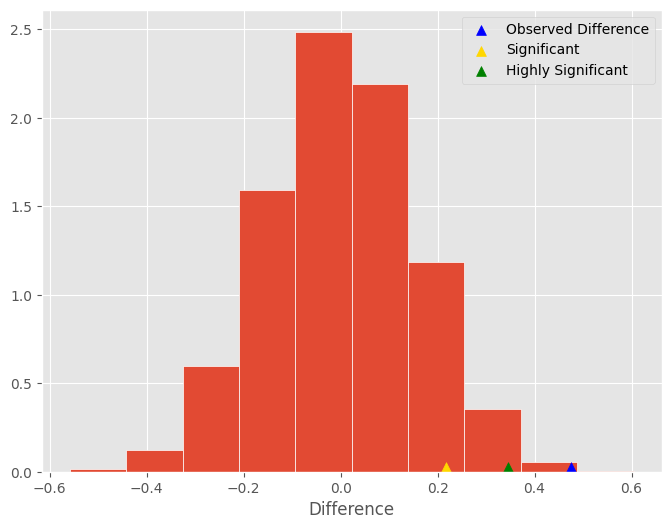

In [29]:
# distribution of differences
plt.hist(differences, density=True, ec="white", bins=10)

# observed difference
plt.scatter(
    observed_difference, 0, c="blue", marker="^", s=200, label="Observed Difference"
)

# significant value
plt.scatter(significant, 0, c="gold", marker="^", s=200, label="Significant");

# highly significant value
plt.scatter(highly_significant, 0, c="green", marker="^", s=200, label="Highly Significant")

plt.xlabel("Difference")

plt.legend(markerscale=0.5);

### Causality

*Because the trials were randomized*, the test is evidence that the treatment *causes* the difference. The random assignment of patients to the two groups ensures that there is no confounding variable that could affect the conclusion of causality.

If the treatment had not been randomly assigned, our test would still point toward an *association* between the treatment and back pain outcomes among our 31 patients.  

But beware: without randomization, this association would not imply that the treatment caused a change in back pain outcomes.  For example, if the patients themselves had chosen whether to administer the treatment, perhaps the patients experiencing more pain would be more likely to choose the treatment *and* more likely to experience some reduction in pain even without medication.  Pre-existing pain would then be a *confounding factor* in the analysis.

## Comments, Suggestions, Corrections

Please send your comments, suggestions, and corrections to lfinotti@utk.edu.